In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
testseries = pd.Series([1, 2, 3, 4, 5, 6, 6, 6, 6, 7, 8])

In [4]:
class LocalLevel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the statespace
        super().__init__(
            endog, k_states=1, k_posdef=1,
            initialization='approximate_diffuse')

        ### Initialize the matrices
        self.ssm['design'] = np.array([1])
        self.ssm['transition'] = np.array([1])
        self.ssm['selection'] = np.eye(1)  # 1x1 identity matrix

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level']

    @property
    def start_params(self):
        return [np.std(self.endog), np.std(self.endog)] # initial value

    def transform_params(self, unconstrained): # transform from sqrt
        return unconstrained**2

    def untransform_params(self, constrained): # non-negative -> sqrt
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super().update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm['state_cov',0,0] = params[1]

In [5]:
# Setup the model
mod = LocalLevel(testseries)

# Fit it using MLE (recall that we are fitting the two variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   11
Model:                     LocalLevel   Log Likelihood                 -20.233
Date:                Thu, 06 May 2021   AIC                             44.465
Time:                        21:37:44   BIC                             45.261
Sample:                             0   HQIC                            43.964
                                 - 11                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  1.225e-11      0.247   4.96e-11      1.000      -0.485       0.485
sigma2.level           0.7000      0.691      1.013      0.311      -0.654       2.054
Ljung-Box (L1) (Q): 

<AxesSubplot:>

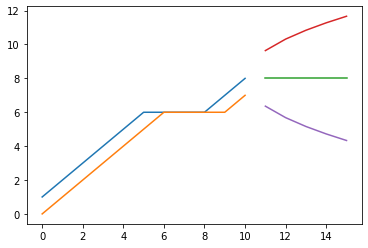

In [7]:
# Perform prediction and forecasting
predict = res.get_prediction() # one step ahead
forecast = res.get_forecast(5) # future 5
plt.figure()
testseries.plot() # blue original
predict.predicted_mean.plot() # yellow one step ahead
forecast.predicted_mean.plot() # green forecatse
forecast.conf_int()["upper y"].plot()
forecast.conf_int()["lower y"].plot()

In [259]:
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the statespace
        super().__init__(
            endog, k_states=2, k_posdef=2,
            initialization='approximate_diffuse')

        #### Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(2)  # 2x2 identity matrix

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend'] ####

    @property
    def start_params(self):
        return [np.std(self.endog), np.std(self.endog), np.std(self.endog)] ####

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super().update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm['state_cov',0,0] = params[1]
        
        ####
        self.ssm['state_cov',1,1] = params[2]

In [260]:
# Setup the model
mod = LocalLinearTrend(testseries)

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   11
Model:               LocalLinearTrend   Log Likelihood                 -21.655
Date:                Mon, 06 Apr 2020   AIC                             49.311
Time:                        20:35:42   BIC                             50.505
Sample:                             0   HQIC                            48.559
                                 - 11                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  4.425e-08    492.328   8.99e-11      1.000    -964.945     964.945
sigma2.level        1.448e-05   2168.668   6.68e-09      1.000   -4250.512    4250.512
sigma2.trend        

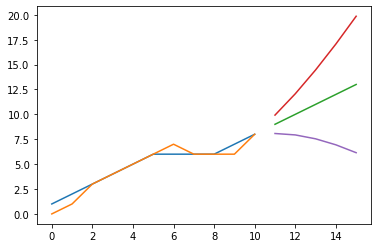

In [228]:
# Perform prediction and forecasting
predict = res.get_prediction()
forecast = res.get_forecast(5)
plt.figure()
testseries.plot()
predict.predicted_mean.plot()
forecast.predicted_mean.plot()
forecast.conf_int()["upper y"].plot()
forecast.conf_int()["lower y"].plot()

In [281]:
class LocalDampedTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the statespace
        super().__init__(
            endog, k_states=2, k_posdef=2,
            initialization='approximate_diffuse')

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['selection'] = np.eye(2)  # 2x2 identity matrix

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend', 'damping']

    @property
    def start_params(self):
        return [np.std(self.endog), np.std(self.endog), np.std(self.endog), 0.5] ####

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super().update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm['state_cov',0,0] = params[1]
        self.ssm['state_cov',1,1] = params[2]
        
        # Transition matrix
        ####
        self.ssm['transition'] = np.array([[1, 1],
                                         [0, params[3]]])


In [282]:
# Setup the model
mod = LocalDampedTrend(testseries)

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   11
Model:               LocalDampedTrend   Log Likelihood                 -21.264
Date:                Mon, 06 Apr 2020   AIC                             50.528
Time:                        20:40:14   BIC                             52.119
Sample:                             0   HQIC                            49.525
                                 - 11                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  2.228e-10      1.221   1.83e-10      1.000      -2.392       2.392
sigma2.level        3.381e-10      5.105   6.62e-11      1.000     -10.006      10.006
sigma2.trend        

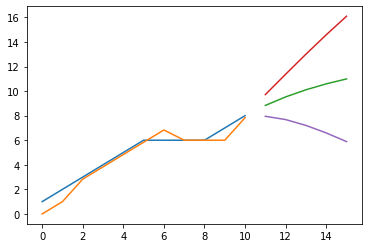

In [283]:
# Perform prediction and forecasting
predict = res.get_prediction()
forecast = res.get_forecast(5)
plt.figure()
testseries.plot()
predict.predicted_mean.plot()
forecast.predicted_mean.plot()
forecast.conf_int()["upper y"].plot()
forecast.conf_int()["lower y"].plot()

In [15]:
stockRtn = [1, 1, -3, 1, -2, -5, -1, 4]
marketRtn = [1, 1, -2, 0, -2, 1, 1, -1]

In [21]:
class TVRegress(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, exog): ####
        # Initialize the statespace
        super().__init__(
            endog, k_states=1, k_posdef=1,
            initialization='approximate_diffuse')

        # Initialize the matrices
        
        ##
        self.ssm['design'] = np.array([[exog]]) ####
        self.ssm['transition'] = np.array([1])
        self.ssm['selection'] = np.eye(1)  # 1x1 identity matrix

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.beta']

    @property
    def start_params(self):
        return [np.std(self.endog), np.std(self.endog)]

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super().update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm['state_cov',0,0] = params[1]

In [22]:
# Setup the model
mod = TVRegress(stockRtn, marketRtn)

# Fit it using MLE (recall that we are fitting the two variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                    8
Model:                      TVRegress   Log Likelihood                 -25.575
Date:                Tue, 07 Apr 2020   AIC                             55.150
Time:                        11:33:53   BIC                             55.309
Sample:                             0   HQIC                            54.079
                                  - 8                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     3.5735      4.588      0.779      0.436      -5.419      12.566
sigma2.beta            2.1799      4.451      0.490      0.624      -6.544      10.904
Ljung-Box (Q):      

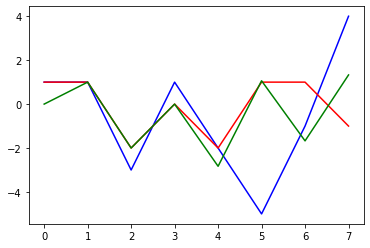

In [23]:
# Perform prediction and forecasting
predict = res.get_prediction()
plt.figure()
plt.plot(stockRtn, "b-")
plt.plot(marketRtn, "r-")
plt.plot(predict.predicted_mean, "g-")

In [24]:
res.states.filtered

array([[ 0.99999643],
       [ 0.99999863],
       [ 1.41536261],
       [ 1.41536261],
       [ 1.06189308],
       [-1.67436589],
       [-1.32713699],
       [-2.74213916]])

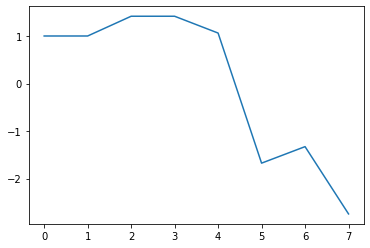

In [25]:
plt.plot(res.states.filtered)